#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
!pip install koreanize_matplotlib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 27.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/MiniProject_3/'

### (2) 라이브러리 설치 및 불러오기

* 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [ ]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df,palette='viridis')

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

In [ ]:
#
def plot_grouped_feature_importance(importance, names, result_only=False, topn='all'):
    # 1. Feature 이름을 기반으로 그룹핑
    features_df = pd.DataFrame({'feature': names, 'importance': importance})

    # 'angle'을 포함하는 feature는 'angle'로 그룹화하고, 나머지는 '-'로 그룹화
    features_df['group'] = features_df['feature'].apply(
        lambda x: 'angle' if 'angle' in x else x.split('-')[0]
    )

    # 2. 그룹별 중요도 계산
    group_importance = features_df.groupby('group')['importance'].sum().reset_index()

    # 3. 그룹별 중요도 순으로 정렬하기
    group_importance.sort_values(by='importance', ascending=False, inplace=True)

    # 4. 상위 N개 그룹 선택
    if topn == 'all':
        fi_df = group_importance.copy()
    else:
        fi_df = group_importance.nlargest(topn, 'importance')

    # 5. 변수의 특성 중요도 그래프로 그리기
    if not result_only:
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='group', data=fi_df, palette='viridis')
        plt.title("sensor별 변수중요도", fontsize=16)
        plt.xlabel('Importance', fontsize=12)
        plt.ylabel('Feature Group', fontsize=12)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.show()

    return group_importance

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [ ]:
df_train = pd.read_csv(path + 'data01_train.csv')
df_test = pd.read_csv(path + 'data01_test.csv')
df_features = pd.read_csv(path + 'features.csv')

In [ ]:
df_train.drop(columns = ['subject'], inplace = True)
df_test.drop(columns = ['subject'], inplace = True)

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


In [ ]:
# 첫 10개 열과 마지막 3개 열을 확인하는 코드
# 중복된 열을 제거하고 하나의 데이터프레임으로 정리
combined_columns_cleaned = pd.concat([df_train.iloc[:, :10], df_train.iloc[:, -4:-1]], axis=1)

# 결과 확인
combined_columns_cleaned


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,"angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,0.264952,0.137758,WALKING_DOWNSTAIRS
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,0.114009,0.080146,SITTING
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,0.303194,-0.044188,WALKING_UPSTAIRS
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,-0.437247,-0.571840,LAYING
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,0.292856,0.024920,WALKING_UPSTAIRS


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [ ]:
df_train.shape, df_test.shape, df_features.shape

((5881, 562), (1471, 562), (561, 4))

In [ ]:
df_train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [ ]:
df_train['Activity'].value_counts()

,count
Activity,
LAYING,1115
STANDING,1087
SITTING,1032
WALKING,998
WALKING_UPSTAIRS,858
WALKING_DOWNSTAIRS,791


In [ ]:
df_train['Activity'].value_counts(normalize = True)

,proportion
Activity,
LAYING,0.189594
STANDING,0.184833
SITTING,0.175480
WALKING,0.169699
WALKING_UPSTAIRS,0.145894
WALKING_DOWNSTAIRS,0.134501


<Axes: xlabel='Activity'>

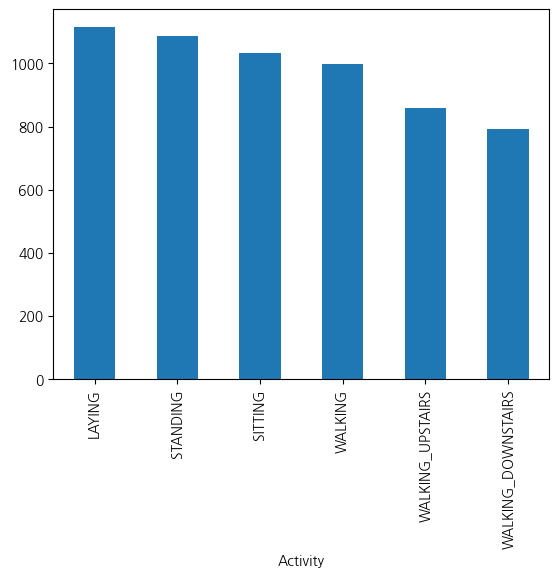

In [ ]:
df_train['Activity'].value_counts().plot(kind = 'bar')

## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [ ]:
x_train = df_train.drop(columns = ['Activity'])
y_train = df_train['Activity']

x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size = 0.2)

#### 2) 모델링

In [ ]:
model_rdf = RandomForestClassifier()
model_rdf.fit(x_train,y_train)
y_pred = model_rdf.predict(x_val)
print(confusion_matrix(y_val,y_pred))
print(classification_report(y_val,y_pred))

[[222   0   0   0   0   0]
 [  0 203   7   0   0   0]
 [  0  10 192   0   0   0]
 [  0   0   0 207   3   2]
 [  0   0   0   2 154   0]
 [  0   0   0   1   0 174]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       222
           SITTING       0.95      0.97      0.96       210
          STANDING       0.96      0.95      0.96       202
           WALKING       0.99      0.98      0.98       212
WALKING_DOWNSTAIRS       0.98      0.99      0.98       156
  WALKING_UPSTAIRS       0.99      0.99      0.99       175

          accuracy                           0.98      1177
         macro avg       0.98      0.98      0.98      1177
      weighted avg       0.98      0.98      0.98      1177



#### 3) 변수 중요도 추출

<ipython-input-5-81cf8abc3555>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='feature_importance', y='feature_name', data = fi_df,palette='viridis')
<ipython-input-6-5c9440f4b448>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='group', data=fi_df, palette='viridis')


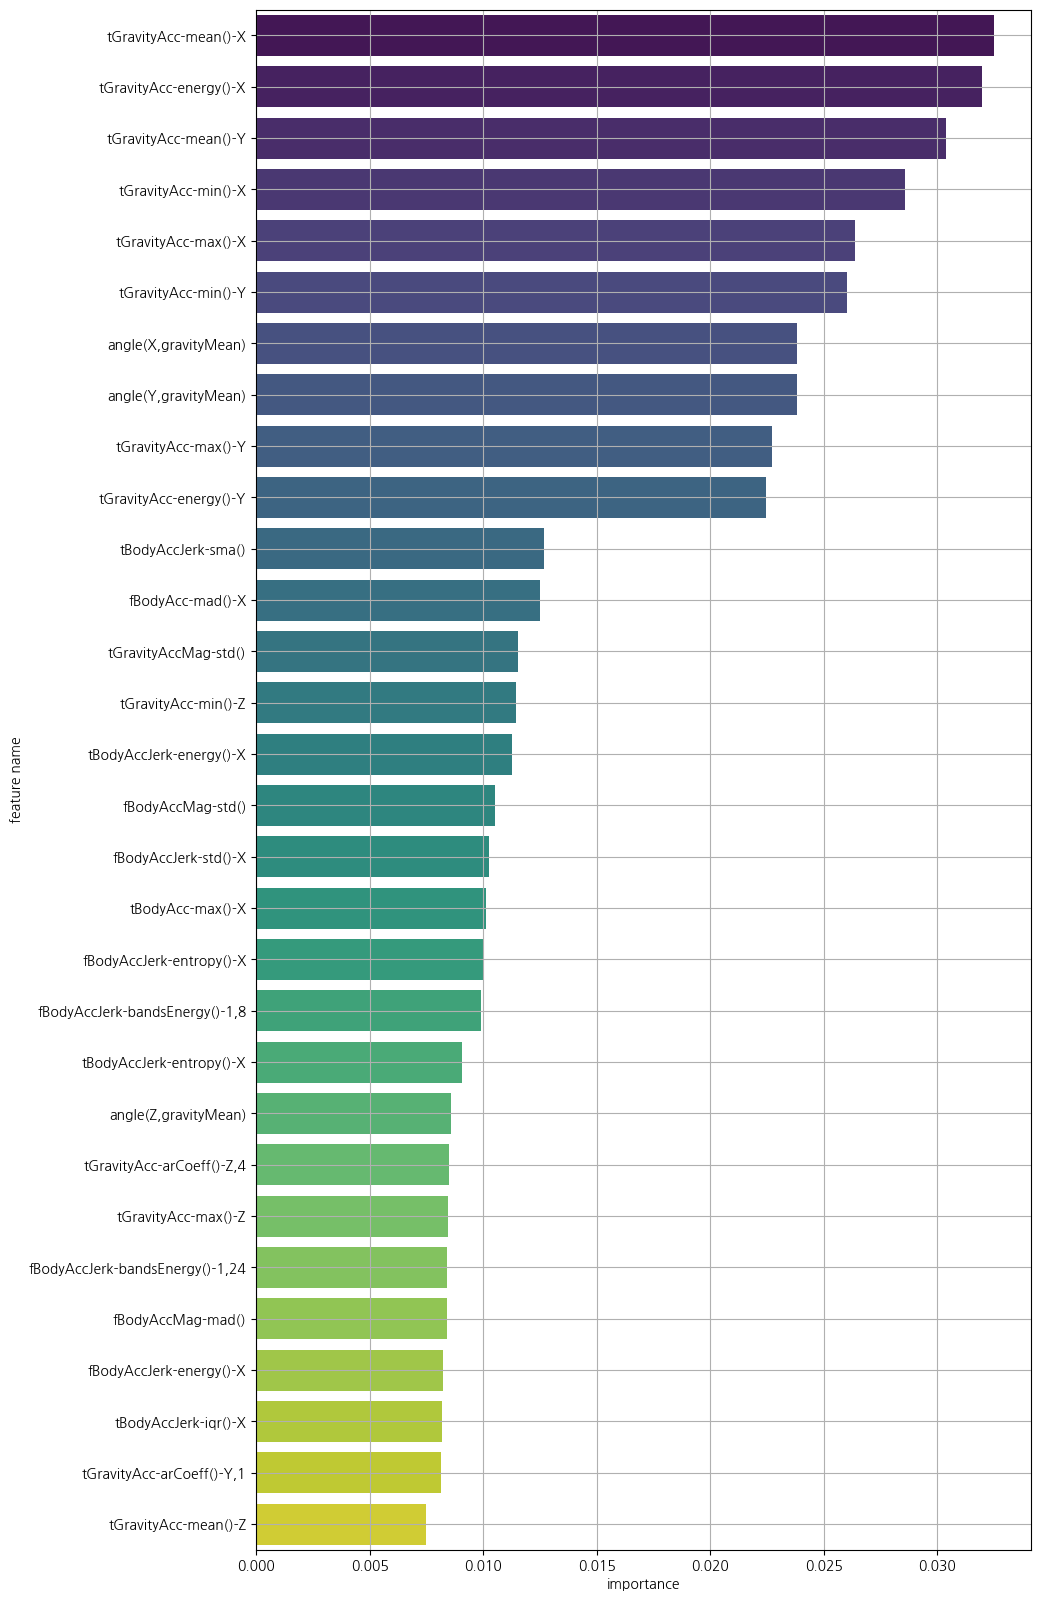

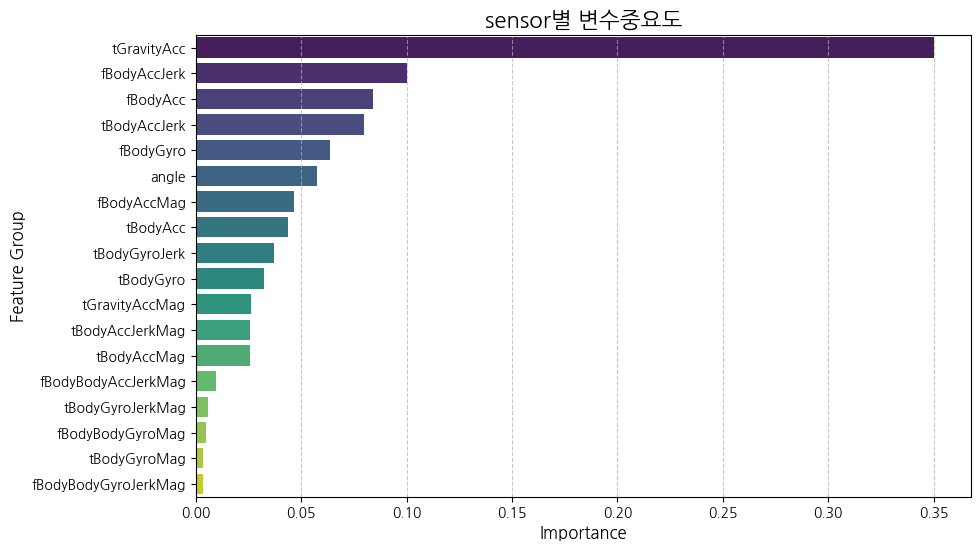

In [ ]:
feature_importance_6clf = plot_feature_importance(model_rdf.feature_importances_,x_train.columns,topn=30)
sensor_importance_6clf = plot_grouped_feature_importance(model_rdf.feature_importances_, x_train.columns, result_only=False, topn=30)

In [ ]:
feature_importance_6clf = plot_feature_importance(model_rdf.feature_importances_,x_train.columns, result_only=True)
sensor_importance_6clf = plot_grouped_feature_importance(model_rdf.feature_importances_, x_train.columns, result_only=True)

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [ ]:
top_value , bottom_value = 16, 3
top_features = plot_feature_importance(model_rdf.feature_importances_,x_train.columns,topn=top_value,result_only=True)
bottom_features = plot_feature_importance(model_rdf.feature_importances_,x_train.columns,topn='all',result_only=True).tail(bottom_value)

In [ ]:
top_features_list = top_features['feature_name'].tolist()
bottom_features_list = bottom_features['feature_name'].tolist()
print(f"상위 {top_value}개 변수\n" + "\n".join(top_features_list))
print(f"하위 {bottom_value}개 변수\n" + "\n".join(bottom_features_list))

상위 16개 변수
tGravityAcc-mean()-X
tGravityAcc-energy()-X
tGravityAcc-mean()-Y
tGravityAcc-min()-X
tGravityAcc-max()-X
tGravityAcc-min()-Y
angle(X,gravityMean)
angle(Y,gravityMean)
tGravityAcc-max()-Y
tGravityAcc-energy()-Y
tBodyAccJerk-sma()
fBodyAcc-mad()-X
tGravityAccMag-std()
tGravityAcc-min()-Z
tBodyAccJerk-energy()-X
fBodyAccMag-std()
하위 3개 변수
fBodyAcc-entropy()-Y
fBodyAccJerk-min()-Z
fBodyBodyGyroMag-entropy()


#### 2) 상위 5개 변수에 대한 분석

분석 대상
: sensor가 중복되지 않게 선정
- tGravityAcc-energy()-X
- angle(X,gravityMean)
- fBodyAccJerk-bandsEnergy()-1,8
- tBodyAccJerk-entropy()-X
- fBodyAcc-mean()-X

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt



def draw_kdeplot(feature, text=None,a=20,b=6):
    plt.figure(figsize=(a, b))
    sns.kdeplot(data=df_train, x=feature, hue='Activity', fill=True, common_norm=False, alpha=0.5)

    plt.title(f"KDE Plot for {feature} by Activity")
    plt.xlabel(feature)
    plt.ylabel('Density')

    # 텍스트 추가 (있는 경우에만)
    if text:
        plt.text(x=0.5, y=0.9, s=text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

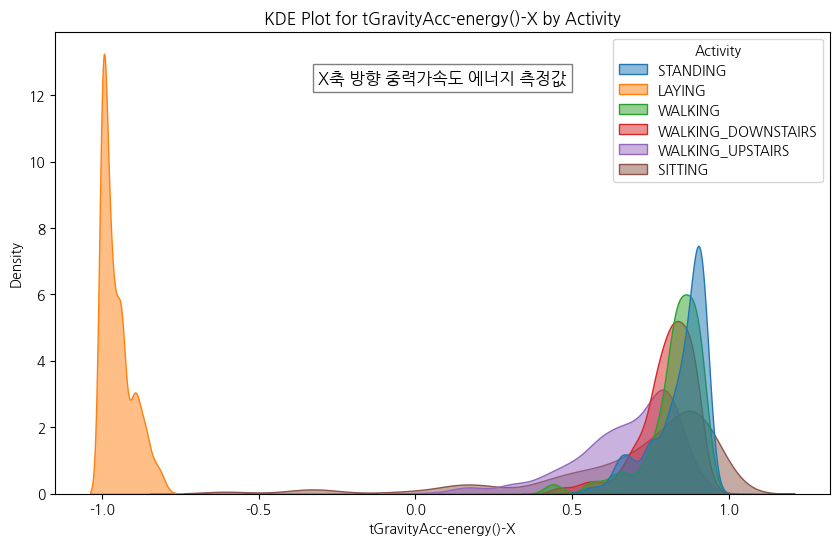

In [156]:
draw_kdeplot('tGravityAcc-energy()-X',text='X축 방향 중력가속도 에너지 측정값',a=10,b=6)

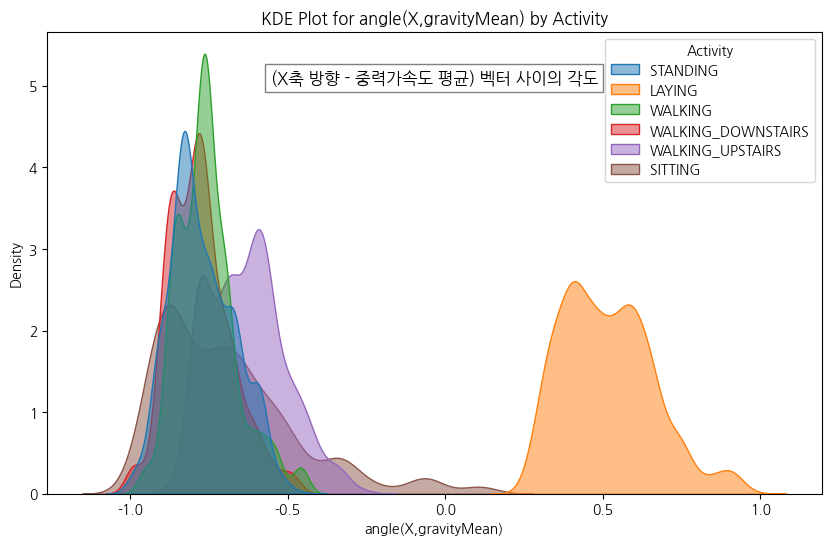

In [157]:
draw_kdeplot('angle(X,gravityMean)',text='(X축 방향 - 중력가속도 평균) 벡터 사이의 각도',a=10,b=6)

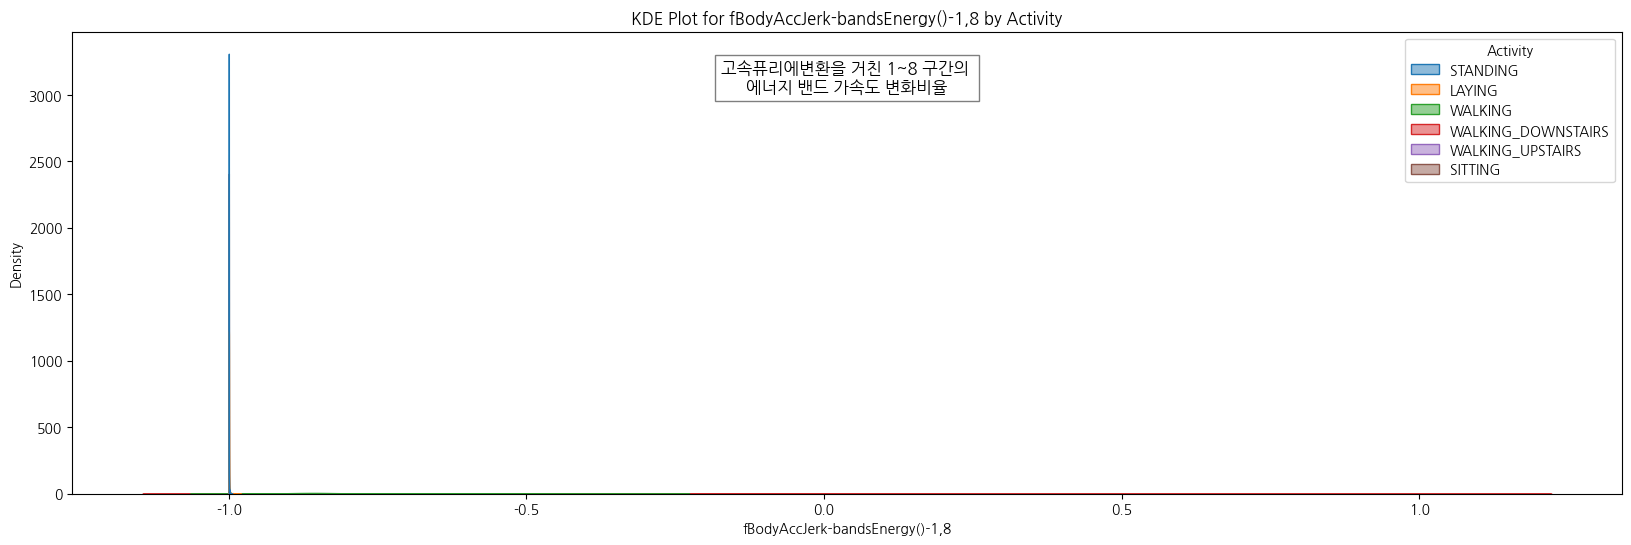

In [ ]:
draw_kdeplot('fBodyAccJerk-bandsEnergy()-1,8',text='고속퓨리에변환을 거친 1~8 구간의 \n에너지 밴드 가속도 변화비율')

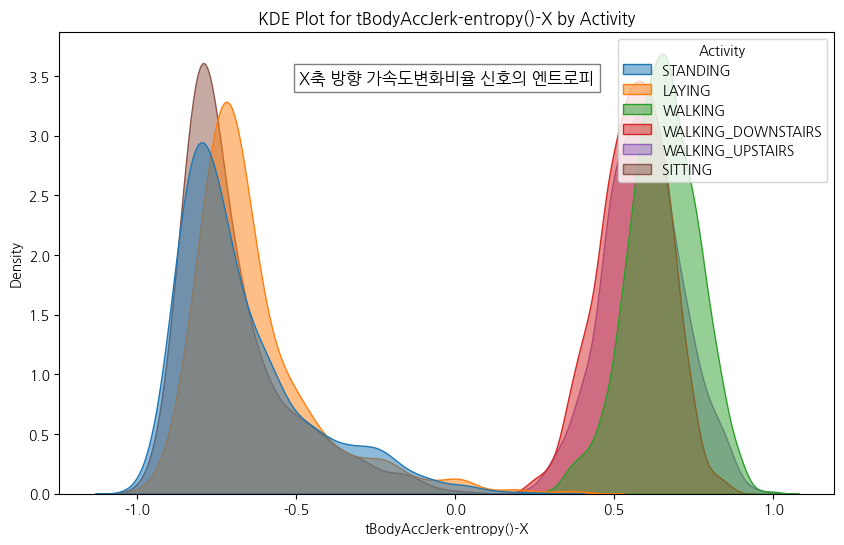

In [158]:
draw_kdeplot('tBodyAccJerk-entropy()-X',text='X축 방향 가속도변화비율 신호의 엔트로피',a=10,b=6)

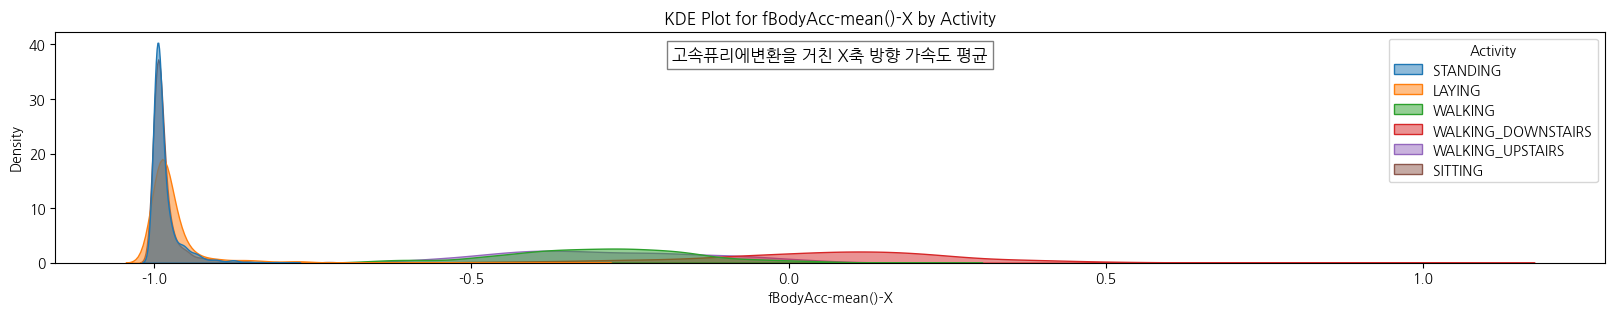

In [ ]:
draw_kdeplot('fBodyAcc-mean()-X',text='고속퓨리에변환을 거친 X축 방향 가속도 평균',a=20,b=3)

#### 3) 하위 5개 변수에 대한 분석

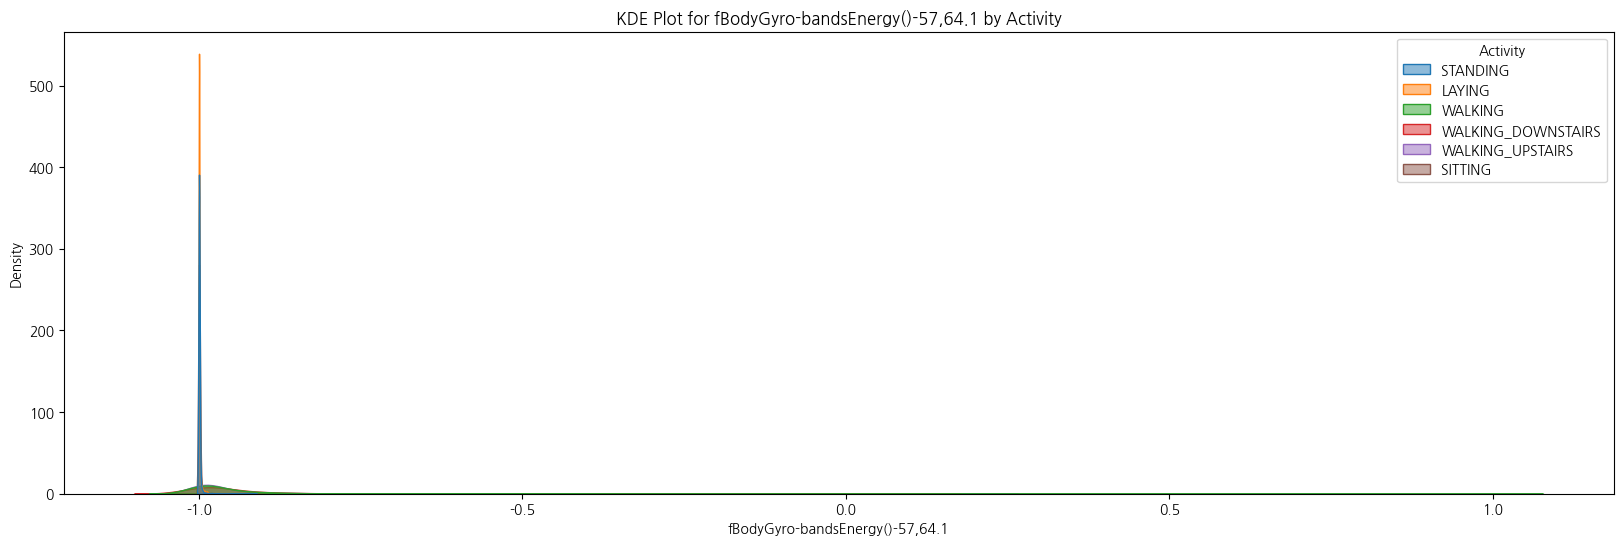

In [ ]:
draw_kdeplot('fBodyGyro-bandsEnergy()-57,64.1')

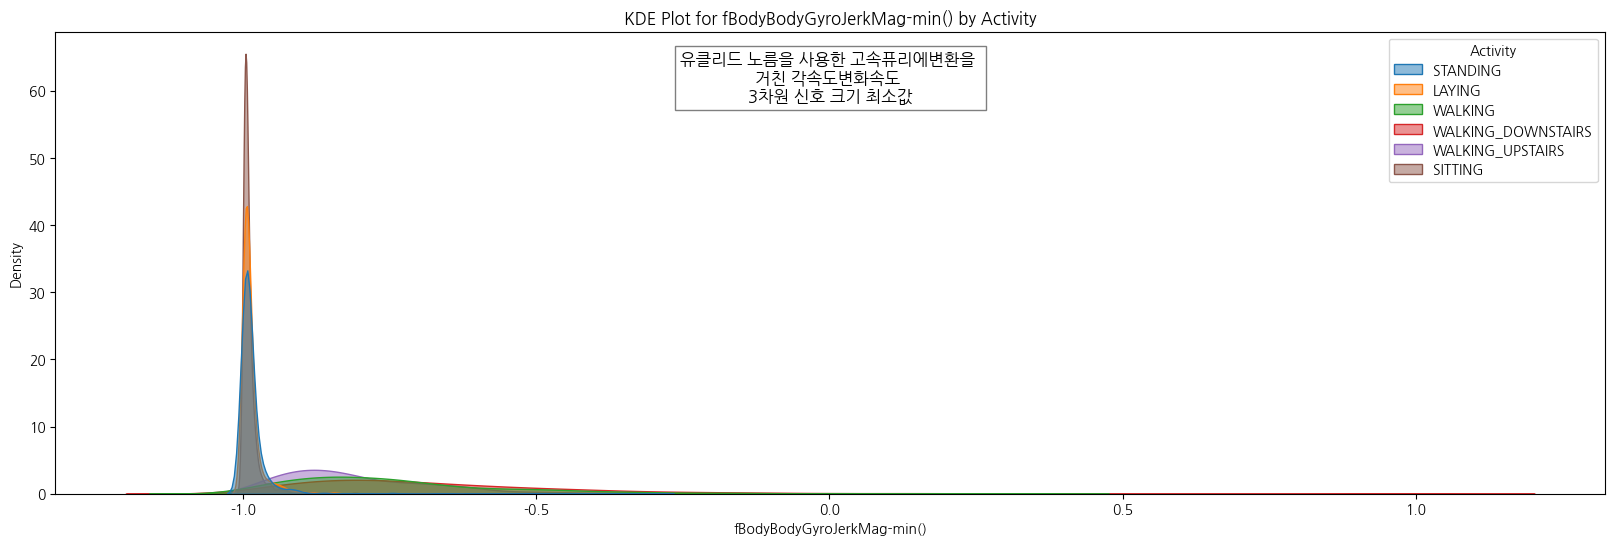

In [ ]:
draw_kdeplot('fBodyBodyGyroJerkMag-min()',text='유클리드 노름을 사용한 고속퓨리에변환을 \n거친 각속도변화속도 \n3차원 신호 크기 최소값')

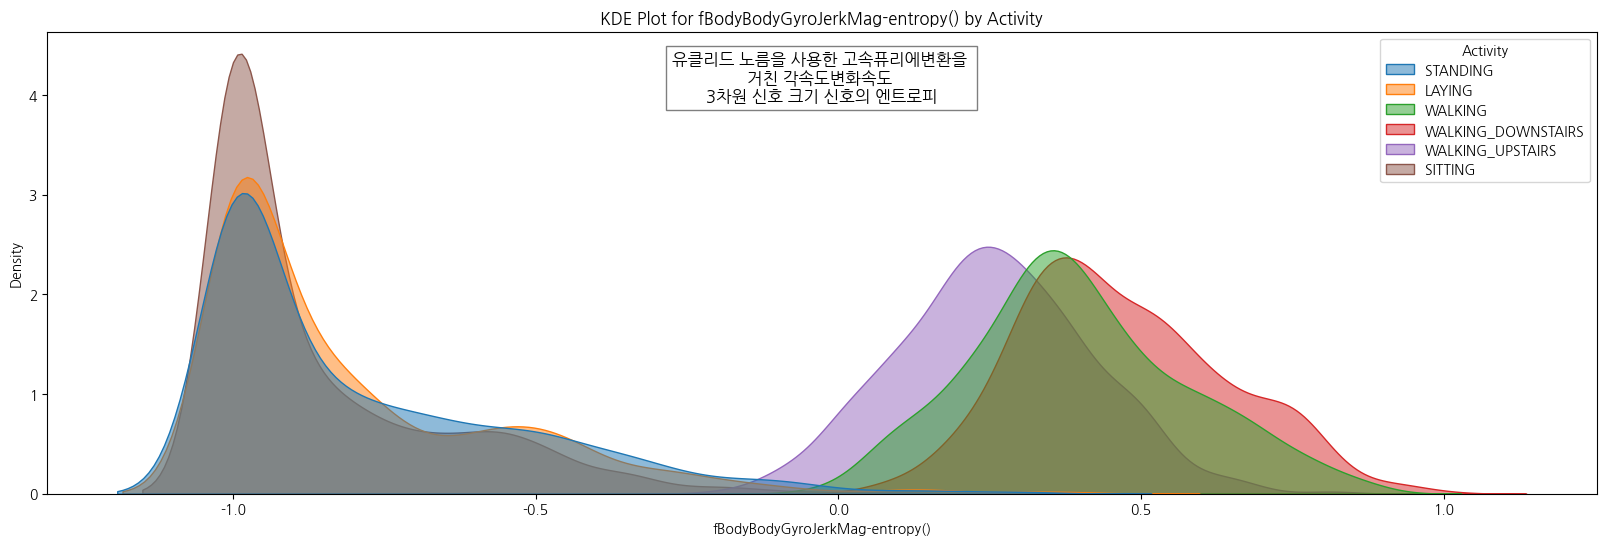

In [ ]:
draw_kdeplot('fBodyBodyGyroJerkMag-entropy()',text='유클리드 노름을 사용한 고속퓨리에변환을 \n거친 각속도변화속도 \n3차원 신호 크기 신호의 엔트로피')

## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [ ]:
df_train['is_dynamic'] = df_train['Activity'].apply(lambda x : 1 if x in ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS'] else 0)
df_test['is_dynamic'] = df_test['Activity'].apply(lambda x : 1 if x in ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS'] else 0)

df_train[['Activity','is_dynamic']]

,Activity,is_dynamic
0,STANDING,0
1,LAYING,0
2,STANDING,0
3,WALKING,1
4,WALKING_DOWNSTAIRS,1
...,...,...
5876,SITTING,0
5877,WALKING_UPSTAIRS,1
5878,LAYING,0
5879,WALKING_UPSTAIRS,1


#### 2) 기본모델 생성

In [ ]:
x_train = df_train.drop(columns = ['is_dynamic','Activity'])
y_train = df_train['is_dynamic']

x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size = 0.2)

In [ ]:
model_rdf1 = RandomForestClassifier()
model_rdf1.fit(x_train,y_train)
y_pred1 = model_rdf1.predict(x_val)
print(confusion_matrix(y_val,y_pred1))
print(classification_report(y_val,y_pred1))

[[632   0]
 [  0 545]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       632
           1       1.00      1.00      1.00       545

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



#### 3) 변수중요도 상위 5개 분석

<ipython-input-6-5c9440f4b448>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='group', data=fi_df, palette='viridis')


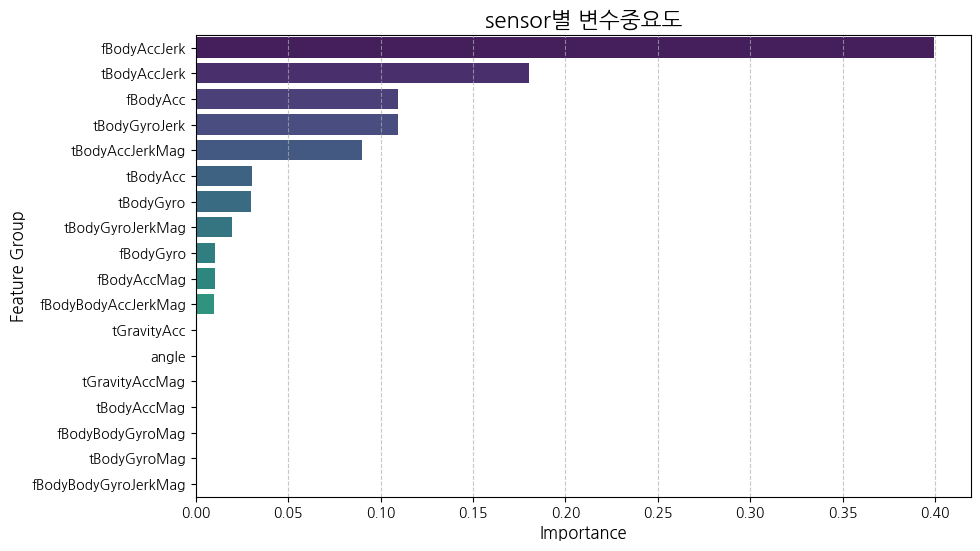

<ipython-input-5-81cf8abc3555>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='feature_importance', y='feature_name', data = fi_df,palette='viridis')


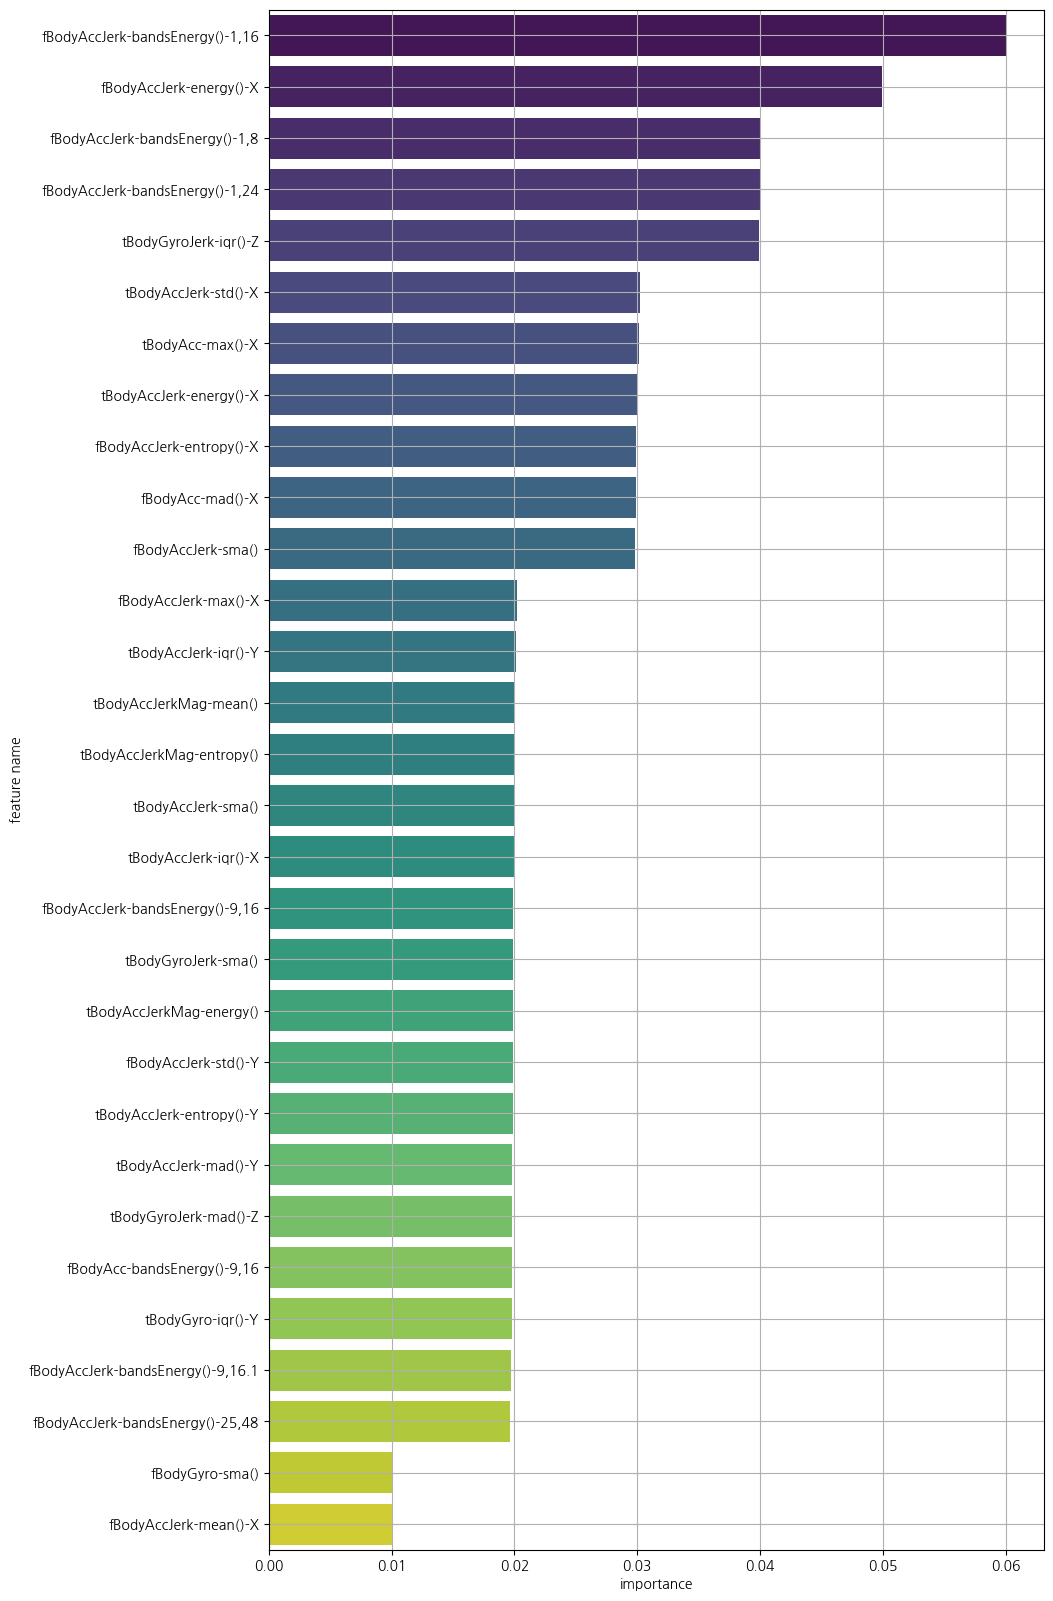

In [ ]:
seonsor_importance_2clf = plot_grouped_feature_importance(model_rdf1.feature_importances_, x_train.columns, result_only=False, topn=30)
feature_importance_2clf = plot_feature_importance(model_rdf1.feature_importances_, x_train.columns, result_only=False, topn=30)

In [ ]:
feature_importance_2clf = plot_feature_importance(model_rdf1.feature_importances_,x_train.columns, result_only=True)
sensor_importance_2clf = plot_grouped_feature_importance(model_rdf1.feature_importances_, x_train.columns, result_only=True)

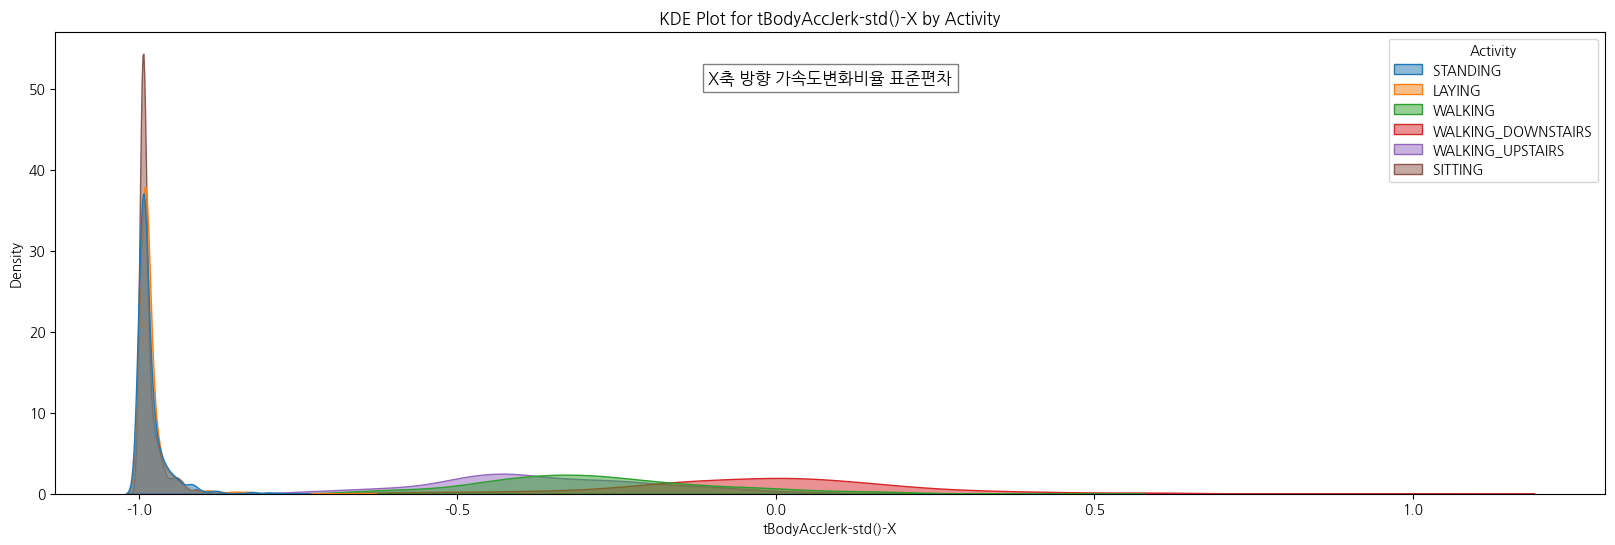

In [ ]:
draw_kdeplot('tBodyAccJerk-std()-X',text='X축 방향 가속도변화비율 표준편차')

## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

#### 1) 이름변경

In [ ]:
feature_importance_6clf = feature_importance_6clf.rename(columns={'feature_importance':'feature_importance_6clf'})
feature_importance_2clf = feature_importance_2clf.rename(columns={'feature_importance':'feature_importance_2clf'})

In [ ]:
sensor_importance_6clf = sensor_importance_6clf.rename(columns={'importance':'importance_6clf'})
sensor_importance_2clf = sensor_importance_2clf.rename(columns={'importance':'importance_2clf'})

#### 2) 합치기

In [ ]:
feature_importance = pd.merge(feature_importance_6clf,feature_importance_2clf,on='feature_name')

In [ ]:
sensor_importance = pd.merge(sensor_importance_6clf,sensor_importance_2clf,on='group')
sensor_importance = sensor_importance.rename(columns={'group':'sensor_name'})

### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.

In [ ]:
feature_importance

,feature_name,feature_importance_6clf,feature_importance_2clf
0,tGravityAcc-mean()-X,0.032514,0.000085
1,tGravityAcc-energy()-X,0.031980,0.000000
2,tGravityAcc-mean()-Y,0.030400,0.000043
3,tGravityAcc-min()-X,0.028561,0.000034
4,tGravityAcc-max()-X,0.026372,0.000034
...,...,...,...
556,fBodyAccJerk-entropy()-Y,0.000085,0.000000
557,"fBodyAcc-bandsEnergy()-57,64.2",0.000081,0.000000
558,fBodyAcc-entropy()-Y,0.000076,0.009915
559,fBodyAccJerk-min()-Z,0.000075,0.000000


In [ ]:
sensor_importance

,sensor_name,importance_6clf,importance_2clf
0,tGravityAcc,0.350128,0.000789
1,fBodyAccJerk,0.099984,0.399324
2,fBodyAcc,0.084141,0.109384
3,tBodyAccJerk,0.079797,0.180293
4,fBodyGyro,0.063842,0.010617
5,angle,0.057545,0.000163
6,fBodyAccMag,0.046518,0.010248
7,tBodyAcc,0.043953,0.030583
8,tBodyGyroJerk,0.037066,0.109268
9,tBodyGyro,0.032170,0.029807


In [ ]:
joblib.dump(feature_importance, f'{path}feature_importance.pkl')
joblib.dump(sensor_importance, f'{path}sensor_importance.pkl')

['/content/drive/MyDrive/MiniProject_3/sensor_importance.pkl']

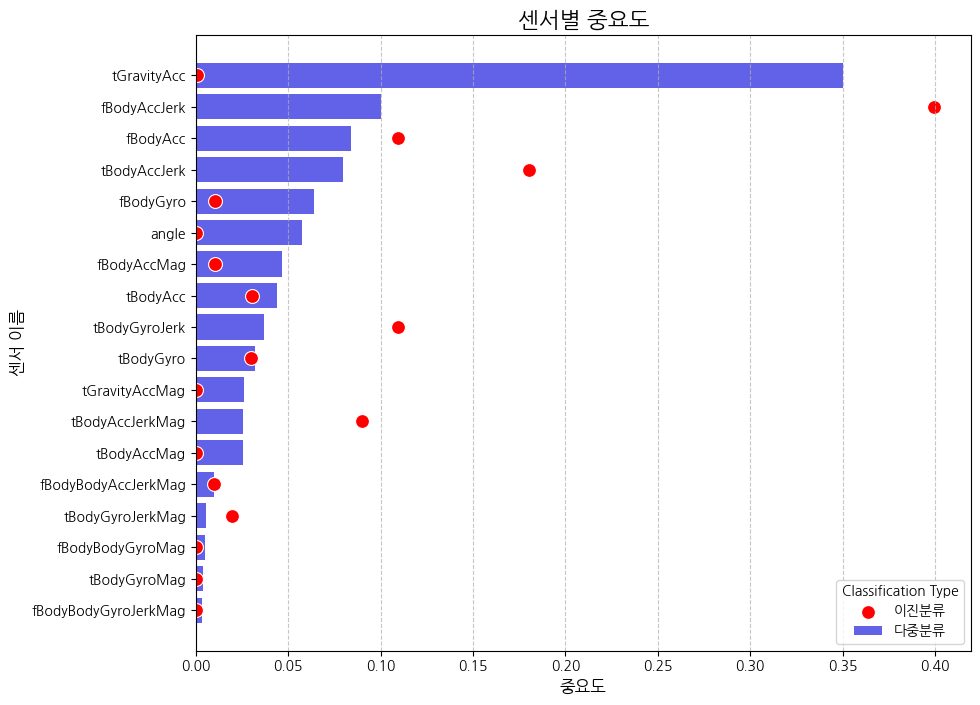

In [ ]:
sensor_importance_sorted = sensor_importance.sort_values(by='importance_6clf', ascending=False)

# 그래프 시각화
plt.figure(figsize=(10, 8))

# 6-class 중요도에 대한 바 플롯
sns.barplot(x='importance_6clf', y='sensor_name', data=sensor_importance_sorted, color='blue', label='다중분류', alpha=0.7)

# 2-class 중요도에 대한 점 플롯
sns.scatterplot(x='importance_2clf', y='sensor_name', data=sensor_importance_sorted, color='red', label='이진분류', s=100, marker='o')

# 타이틀 및 레이블 설정
plt.title("센서별 중요도", fontsize=16)
plt.xlabel("중요도", fontsize=12)
plt.ylabel("센서 이름", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# 범례 설정
plt.legend(title='Classification Type', loc='lower right')
plt.show()


- 6가지의 행동을 분류하는 데에 필요한 센서와
- 동적인 행동인지 정적인 행동인지 분류하는 센서는 차이가 있는 것으로 보여졌다.
- 따라서 먼저 정적인지 동적인지를 분류한 후에
- 그 이후에 어떤 행동을 하고 있는 지 분류하는 모델을 만들면 좋겠다고 생각이 된다.